# **Economic Well-Being Prediction Challenge**

In [1]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 317 kB/s 


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve

from category_encoders import CountEncoder

import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
from collections import Counter 

import random
random.seed(123)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading the Data


In [3]:
train = pd.read_csv('Train.csv')
print(train.shape)
train.head(3)

(21454, 19)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.0,0.00000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.0,0.000000,0.0,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.0,0.00011,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.0,0.005427,0.0,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.0,0.00000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.0,0.003078,0.0,642.594208,169.913773,0.097320


In [4]:
test = pd.read_csv('Test.csv')
print(test.shape)
test.head(3)

(7194, 18)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,Uganda,2011,U,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334


In [5]:
ss = pd.read_csv('SampleSubmission.csv')
print(ss.shape)
ss.head(3)

(7194, 2)


,ID,Target
0,ID_AAcismbB,0
1,ID_AAeBMsji,0
2,ID_AAjFMjzy,0


In [6]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

all_data = all_data.drop_duplicates()
print('Shape After deleting duplicate values:', all_data.shape)

The shape of the combined dataframe is: (28648, 19)
Shape After deleting duplicate values: (28648, 19)


In [7]:
all_data = all_data.drop('ID', axis=1)

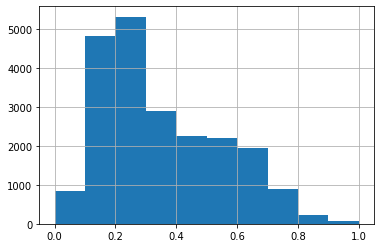

In [8]:
%matplotlib inline
# target distribution
train['Target'].hist() 

# Data Exploration

In [9]:
date_cols = [col for col in all_data.columns if 'year' in col]
cat_cols  = ['country','urban_or_rural']

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = all_data[col].astype('int64') 
  if col in cat_cols:
    all_data[col] = all_data[col].astype('category') #changing 'object' dtype to 'category'


In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28648 entries, 0 to 28647
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   country                                  28648 non-null  category
 1   year                                     28648 non-null  int64   
 2   urban_or_rural                           28648 non-null  category
 3   ghsl_water_surface                       28648 non-null  float64 
 4   ghsl_built_pre_1975                      28648 non-null  float64 
 5   ghsl_built_1975_to_1990                  28648 non-null  float64 
 6   ghsl_built_1990_to_2000                  28648 non-null  float64 
 7   ghsl_built_2000_to_2014                  28648 non-null  float64 
 8   ghsl_not_built_up                        28648 non-null  float64 
 9   ghsl_pop_density                         28648 non-null  float64 
 10  landcover_crops_fraction          

In [11]:
# central tendencies
all_data.describe(include='all')

,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
count,28648,28648.000000,28648,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,28648.000000,21454.000000
unique,25,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Nigeria,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2695,NaN,18674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2010.271537,NaN,0.027018,0.041010,0.027820,0.013713,0.018369,0.872069,95.101508,21.097237,14.079153,1.668968,0.694652,9.260498,300.584775,473.801360,0.350736
std,NaN,4.553145,NaN,0.095199,0.118721,0.072850,0.034208,0.040241,0.242707,210.079701,16.309999,23.917510,7.152657,2.383790,26.160952,269.097712,355.856845,0.194376
min,NaN,1994.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105306,0.112080,0.000000
25%,NaN,2008.000000,NaN,0.000000,0.000000,0.000000,0.000037,0.000109,0.895615,2.943082,6.105505,0.705307,0.000000,0.001394,0.000000,110.789483,158.829182,0.195772
50%,NaN,2011.000000,NaN,0.000000,0.000160,0.000602,0.000936,0.001727,0.992725,16.424158,19.297194,2.599028,0.000579,0.033941,0.024074,253.537926,420.442368,0.293574
75%,NaN,2014.000000,NaN,0.000000,0.008011,0.010037,0.008823,0.015209,0.999592,64.364772,33.199903,13.063126,0.172243,0.375420,4.963472,403.780077,732.552186,0.499003


### Categorical variables

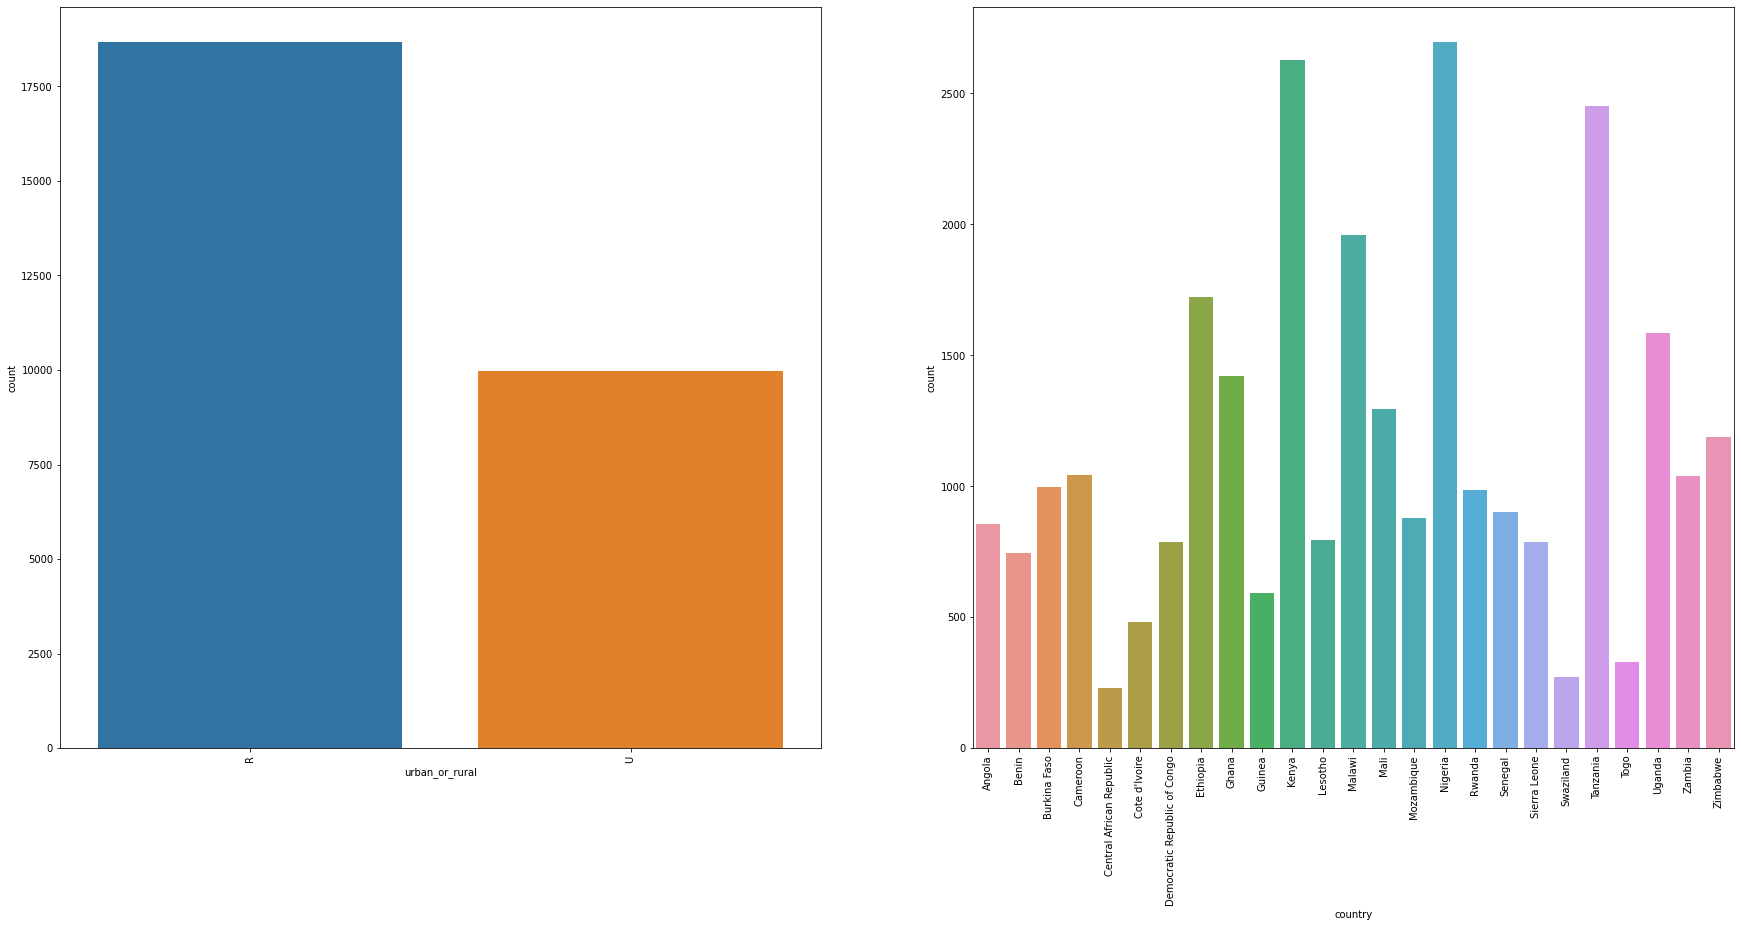

In [12]:
# countplots 
catCols=['urban_or_rural', 'country']
plt.figure(figsize=(30,30))
for i in enumerate(catCols):
  plt.subplot(2, 2, i[0]+1)
  sns.countplot(i[1], data=all_data)
  plt.xticks(rotation=90)

- Most of the data describe a cluster from a rural ('R') setting.

- The majority of the data are from Kenya, Nigeria and Tanzania.



## Numerical variables


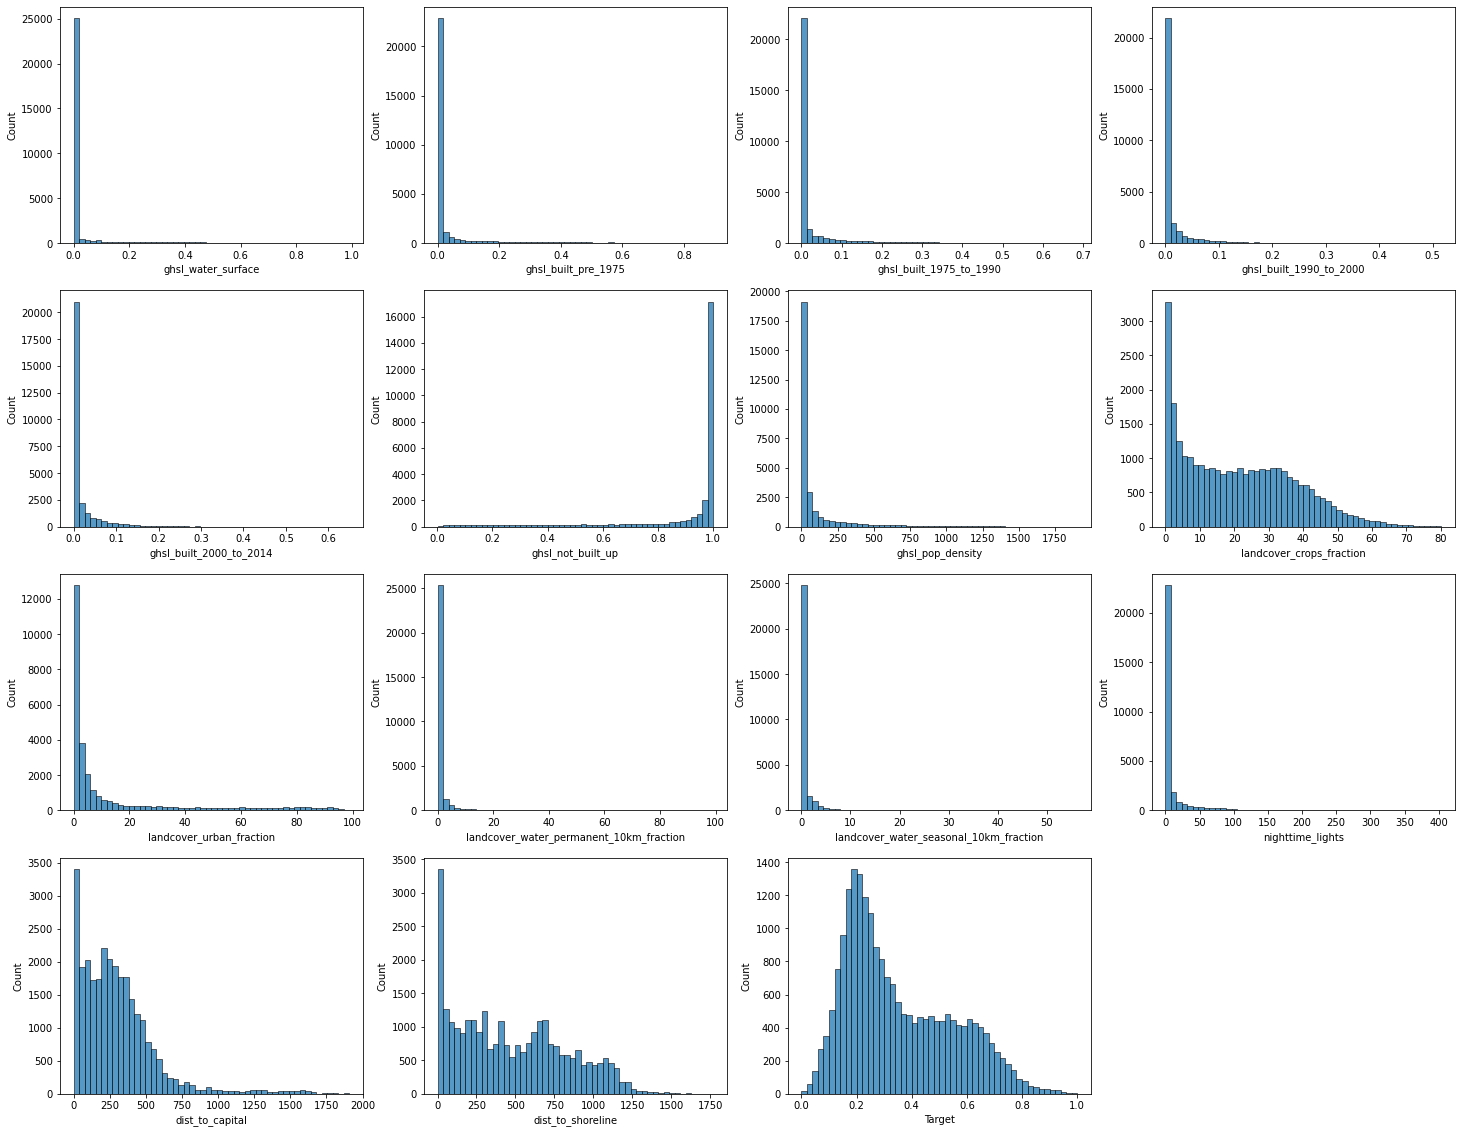

In [15]:
# histograms 
nums = all_data.drop(['country', 'year', 'urban_or_rural'], axis=1)
plt.figure(figsize=(25,20))
for i in enumerate(nums.columns):
  plt.subplot(4, 4, i[0]+1)
  sns.histplot(all_data[i[1]], bins=50)
plt.show()

In [16]:
# correlation matrix
Correlation=all_data.drop(['country', 'year', 'urban_or_rural'], axis=1).corr()
Correlation

,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
ghsl_water_surface,1.000000,0.197961,0.110012,0.040389,0.034900,-0.533573,0.137382,-0.221121,0.246438,0.639638,0.185985,0.171599,-0.030484,-0.152016,0.182816
ghsl_built_pre_1975,0.197961,1.000000,0.474982,0.464407,0.281641,-0.821521,0.816594,-0.337366,0.804210,0.079085,0.053655,0.746656,-0.147007,-0.186005,0.450119
ghsl_built_1975_to_1990,0.110012,0.474982,1.000000,0.451552,0.445210,-0.713104,0.658810,-0.298848,0.750170,0.042565,0.070884,0.567003,-0.186747,-0.151022,0.500753
ghsl_built_1990_to_2000,0.040389,0.464407,0.451552,1.000000,0.574375,-0.614719,0.507582,-0.257735,0.638640,0.017545,0.017371,0.414382,-0.166710,-0.142295,0.425059
ghsl_built_2000_to_2014,0.034900,0.281641,0.445210,0.574375,1.000000,-0.531842,0.416470,-0.226773,0.587058,0.003370,0.023246,0.355522,-0.167433,-0.088179,0.429262
ghsl_not_built_up,-0.533573,-0.821521,-0.713104,-0.614719,-0.531842,1.000000,-0.791663,0.415382,-0.902559,-0.305384,-0.126775,-0.720076,0.191176,0.230617,-0.580670
ghsl_pop_density,0.137382,0.816594,0.658810,0.507582,0.416470,-0.791663,1.000000,-0.323615,0.860147,0.044945,0.038811,0.761638,-0.162155,-0.164513,0.525206
landcover_crops_fraction,-0.221121,-0.337366,-0.298848,-0.257735,-0.226773,0.415382,-0.323615,1.000000,-0.377178,-0.112033,-0.096018,-0.304454,-0.055470,0.281731,-0.253550
landcover_urban_fraction,0.246438,0.804210,0.750170,0.638640,0.587058,-0.902559,0.860147,-0.377178,1.000000,0.059166,0.066508,0.761303,-0.214692,-0.214850,0.666768
landcover_water_permanent_10km_fraction,0.639638,0.079085,0.042565,0.017545,0.003370,-0.305384,0.044945,-0.112033,0.059166,1.000000,0.110541,0.035453,0.001938,0.060882,0.017210


#**Preprocessing + Feature engineering**

#### **Missing values**

In [17]:
all_data.isna().sum() # Hooray - no missing data!

country                                       0
year                                          0
urban_or_rural                                0
ghsl_water_surface                            0
ghsl_built_pre_1975                           0
ghsl_built_1975_to_1990                       0
ghsl_built_1990_to_2000                       0
ghsl_built_2000_to_2014                       0
ghsl_not_built_up                             0
ghsl_pop_density                              0
landcover_crops_fraction                      0
landcover_urban_fraction                      0
landcover_water_permanent_10km_fraction       0
landcover_water_seasonal_10km_fraction        0
nighttime_lights                              0
dist_to_capital                               0
dist_to_shoreline                             0
Target                                     7194
dtype: int64

#### **Creating new features**

In [18]:
all_data['total_ghl_built'] = all_data['ghsl_built_pre_1975'] + all_data['ghsl_built_1975_to_1990'] + all_data['ghsl_built_1990_to_2000'] + all_data['ghsl_built_2000_to_2014'] + all_data['ghsl_not_built_up']
all_data['total_landcover'] = all_data['landcover_crops_fraction'] + all_data['landcover_urban_fraction'] 
all_data['total_water'] = all_data['landcover_water_permanent_10km_fraction'] +all_data['landcover_water_seasonal_10km_fraction'] 

#### **Encoding**

In [19]:
all_data['urban_or_rural']=all_data['urban_or_rural'].map({'U':1, 'R':2})
all_data['urban_or_rural'] = all_data['urban_or_rural'].astype('int64')
all_data['urban_or_rural'].unique()

array([2, 1])

In [20]:
all_data.country.unique()

['Ethiopia', 'Mozambique', 'Malawi', 'Guinea', 'Cameroon', ..., 'Burkina Faso', 'Zambia', 'Angola', 'Zimbabwe', 'Benin']
Length: 25
Categories (25, object): ['Ethiopia', 'Mozambique', 'Malawi', 'Guinea', ..., 'Zambia', 'Angola',
                          'Zimbabwe', 'Benin']

In [21]:
# Count encoding for 'country' column
all_data['country'] = CountEncoder().fit_transform(all_data['country'])

In [22]:
all_data['country'].unique()

array([1721,  879, 1957,  593, 1041, 1419,  903, 2626, 2450, 1295,  270,
        984, 2695,  794,  785,  231,  481,  330, 1584,  997, 1038,  855,
       1189,  746])

#### **Separate train and test data from the combined dataframe**


In [23]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Create target variable
y = train['Target']
# Create feature variable
X = train.drop(columns=['Target'], axis=1)


test = test.drop(columns=['Target'], axis=1) 

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("test shape: ", test.shape)

X shape:  (21454, 20)
y shape:  (21454,)
test shape:  (7194, 20)


#**Machine learning**

#### **LightGBM**

In [24]:
lgbm = LGBMRegressor(objectve='regression', learning_rate=0.22,n_estimators = 95,
                               reg_alpha=0.0 ,metrics='root_mean_squared_error'
                               ,max_depth=16,num_leaves=49,reg_lambda=0.3)

xgboost = XGBRegressor(eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, 
                          tree_method='gpu_hist', gpu_id=0
                        )

In [25]:
def training_model(model, modelName, train, test):

  rmse_scores = []
  kf = KFold(n_splits = 12)
  y_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])

  def lightgbm_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train, y_train, eval_metric="root_mean_squared_error", early_stopping_rounds = 10,
                           eval_set=[(x_test, y_test), (x_train, y_train)], verbose = True)
    y_pred = model.predict(x_test, num_iteration = model.best_iteration_)
    y_preds[test_index] = y_pred 
    y_train_pred = model.predict(x_train, num_iteration = model.best_iteration_)
    test_preds += model.predict(test, num_iteration = model.best_iteration_)
    lgb.plot_metric(model, title='RMSE during training fold ') #plot error loss
    return y_pred, y_train_pred
#------------------------------------------------------------------------------------------------
  def xgboost_(x_train, x_test, y_train, y_test, test_preds):
    model.fit(x_train, y_train, eval_metric="rmse", early_stopping_rounds = 30,
                           eval_set=[(x_test, y_test), (x_train, y_train)], verbose = True)
    y_pred = model.predict(x_test, ntree_limit = model.get_booster().best_ntree_limit)
    y_train_pred = model.predict(x_train, ntree_limit = model.get_booster().best_ntree_limit)
    y_preds[test_index] = y_pred 
    test_preds += model.predict(test, ntree_limit = model.get_booster().best_ntree_limit)
    results = model.evals_result()
    iterations = len(results['validation_0']['error'])
    x_axis = range(0, iterations)
    fig, ax = pyplot.subplots(figsize=(12,12))
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train') #plot error loss
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    pyplot.ylabel('rmse')
    pyplot.title('XGBoost rmse')
    pyplot.show()
    return y_pred, y_train_pred
#------------------------------------------------------------------------------------------------
  for count, (train_index, test_index) in enumerate(kf.split(X, y)):
      x_train,x_test = X.iloc[train_index], X.iloc[test_index]
      y_train,y_test = y.iloc[train_index], y.iloc[test_index]
      print(f"================================Fold {count+1}====================================")

      if modelName == 'xgboost':
        y_pred, y_train_pred = xgboost_(x_train, x_test, y_train, y_test, test_preds)
      elif modelName == 'lightgbm':
        y_pred, y_train_pred = lightgbm_(x_train, x_test, y_train, y_test, test_preds)
      
      print('\nTraining rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
      print('\nValidation rmse:', np.sqrt(mean_squared_error(y_test, y_pred)))

      rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
      
  print('Mean rmse ', np.mean(rmse_scores))
  return y_preds, test_preds/12

================================Fold 1====================================
[1]	training's rmse: 0.164474	valid_0's rmse: 0.165154
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 0.142783	valid_0's rmse: 0.142982
[3]	training's rmse: 0.127122	valid_0's rmse: 0.127404
[4]	training's rmse: 0.115741	valid_0's rmse: 0.116246
[5]	training's rmse: 0.107537	valid_0's rmse: 0.108108
[6]	training's rmse: 0.10145	valid_0's rmse: 0.102383
[7]	training's rmse: 0.0973155	valid_0's rmse: 0.0984622
[8]	training's rmse: 0.0940938	valid_0's rmse: 0.0951515
[9]	training's rmse: 0.0915119	valid_0's rmse: 0.0929252
[10]	training's rmse: 0.0893078	valid_0's rmse: 0.0910049
[11]	training's rmse: 0.0879031	valid_0's rmse: 0.0899435
[12]	training's rmse: 0.0866383	valid_0's rmse: 0.0893033
[13]	training's rmse: 0.0855241	valid_0's rmse: 0.0883563
[14]	training's rmse: 0.0846324	valid_0's rmse: 0.0877751
[15]	training's rmse: 0.0839452	valid_0's rmse: 0.0875583
[16]	training's

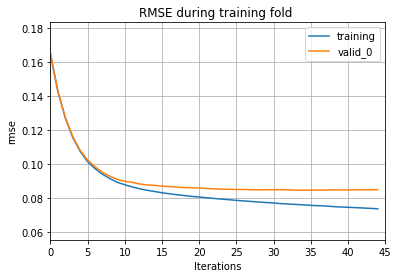

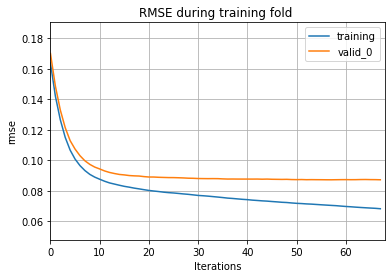

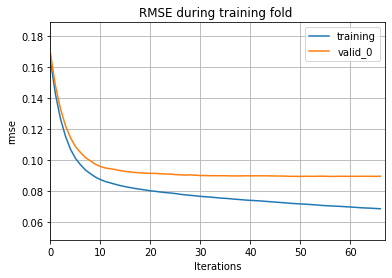

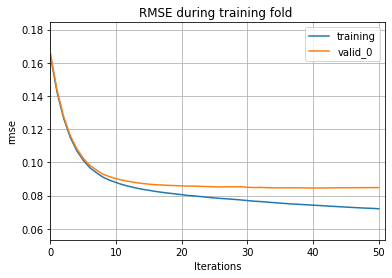

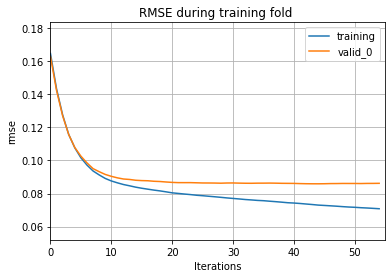

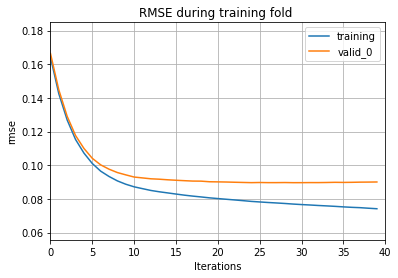

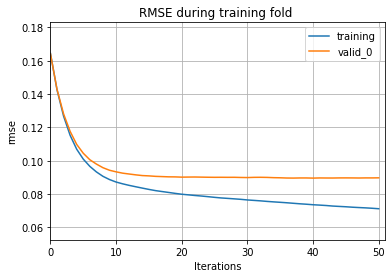

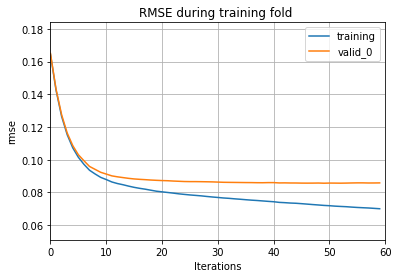

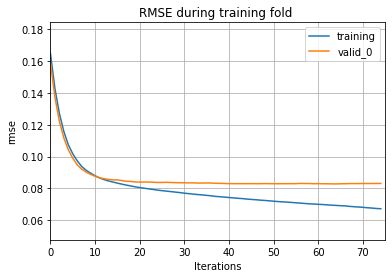

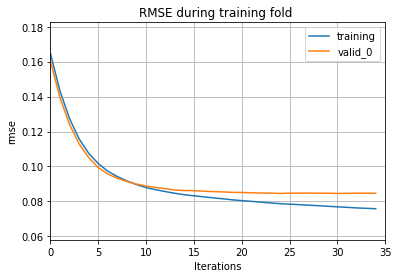

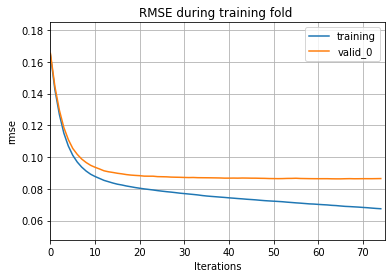

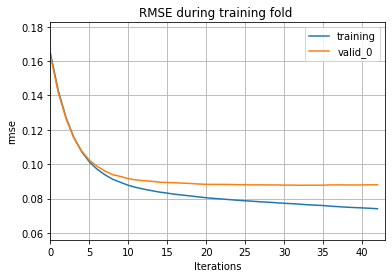

In [26]:
y_preds_lgbm, test_preds_lgbm = training_model(lgbm, "lightgbm", train, test)

In [27]:
predictions = ss.copy()
predictions.Target = test_preds_lgbm
predictions.to_csv('test_preds_lgbm.csv', index=False)

FURTHER IMPROVEMENTS TO DO:

* outliers
* Scaling ?